In [ ]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from image_utils import read_gz_file, open_all_ims_in_dir
from scipy.ndimage import gaussian_filter


def gaussian(x, a, x0, sigma, offset):
    return a * np.exp(-((x - x0) ** 2) / (2 * sigma**2)) + offset


roi = {
    "xMain": np.array([620, 1400]),
    "yMain": np.array([416, 800]),
}

file_list = open_all_ims_in_dir("Absorptiondata/1")

x_length = roi["xMain"][1] - roi["xMain"][0]
y_length = roi["yMain"][1] - roi["yMain"][0]

x_vals_centered = np.arange(x_length) - x_length / 2
y_vals_centered = np.arange(y_length) - y_length / 2

file_indices = []
x0_values = []
sigma_x_values = []
y0_values = []
sigma_y_values = []
dt = 250 * 1e-6  # TOF step size in seconds
start_tof = 71 * 1e-6  # Start time of flight in seconds
time_stamps = np.arange(len(file_list)) * dt

min_file = 23
max_file = 63

for file in file_list:
    file_index = int(file[-5:-3])
    
    if file_index < min_file:
        continue
    if file_index > max_file:
        break
    
    img = read_gz_file(file, returnRaw=False, returnDict=False)
    cropped = img[slice(*roi["yMain"]), slice(*roi["xMain"])]

    projection_x = np.sum(cropped, axis=0)
    projection_y = np.sum(cropped, axis=1)

    initial_params = [20, 0, 50, -30]

    try:
        popt_x, _ = curve_fit(gaussian, x_vals_centered, projection_x, p0=initial_params)
        popt_y, _ = curve_fit(gaussian, y_vals_centered, projection_y, p0=initial_params)
    except:
        popt_x = initial_params  # Default values if fit fails
        popt_y = initial_params

    file_indices.append(file_index)
    x0_values.append(popt_x[1] + x_length / 2 + roi["xMain"][0])
    sigma_x_values.append(abs(popt_x[2]))
    y0_values.append(popt_y[1] + y_length / 2 + roi["yMain"][0])
    sigma_y_values.append(abs(popt_y[2]))

    plt.plot(x_vals_centered + x_length / 2 + roi["xMain"][0], projection_x, label="X Projection")
    plt.plot(
        x_vals_centered + x_length / 2 + roi["xMain"][0],
        gaussian(x_vals_centered, *popt_x),
        label="Gaussian Fit X",
        linestyle="--",
        linewidth=3,
    )
    plt.title(f"Gaussian Fit along x axis of image # {file[-5:-3]}")
    #plt.savefig("gaussian_fit_x.png", dpi=600)
    plt.show()

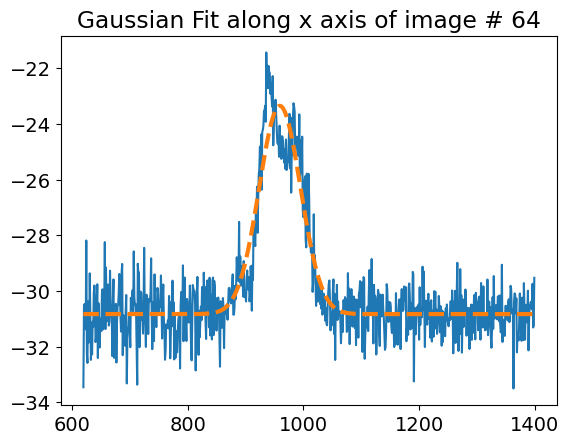

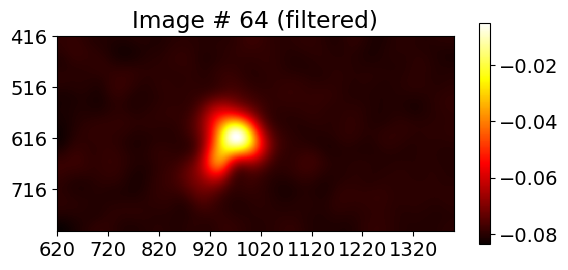

In [24]:
# Example
plt.plot(x_vals_centered + x_length / 2 + roi["xMain"][0], projection_x, label="X Projection")
plt.plot(
    x_vals_centered + x_length / 2 + roi["xMain"][0],
    gaussian(x_vals_centered, *popt_x),
    label="Gaussian Fit X",
    linestyle="--",
    linewidth=3,
)
plt.title(f"Gaussian Fit along x axis of image # {file[-5:-3]}")
#plt.savefig("gaussian_fit_x.png", dpi=600)
plt.show()

# Apply 2D gauss filter
cropped = gaussian_filter(cropped, sigma=20)

plt.imshow(cropped, cmap="hot", interpolation="nearest")
plt.colorbar(shrink=0.6)
plt.xticks(np.arange(0, x_length, 100), np.arange(roi["xMain"][0], roi["xMain"][1], 100))
plt.yticks(np.arange(0, y_length, 100), np.arange(roi["yMain"][0], roi["yMain"][1], 100))
plt.title(f"Image # {file[-5:-3]} (filtered)")
#plt.savefig("2D_image.png", dpi=600)
plt.show()

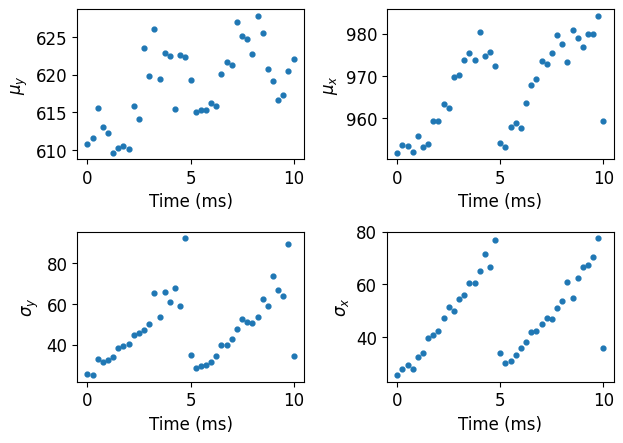

In [25]:
# Plot gaussian fit parameters of all images
time_stamps_ms = time_stamps * 1e3 
time_stamps_ms_selected = time_stamps_ms[min_file:(max_file+1)] - time_stamps_ms[min_file]
plt.rcParams.update({'font.size': 12})
plt.subplot(2, 2, 1)
plt.scatter(time_stamps_ms_selected, y0_values, label="y0", s=12)
plt.xlabel("Time (ms)")
plt.ylabel(r'$\mu_y$')
plt.subplot(2, 2, 2)
plt.scatter(time_stamps_ms_selected, x0_values, label="x0", s=12)
plt.xlabel("Time (ms)")
plt.ylabel(r'$\mu_x$')
plt.subplot(2, 2, 3)
plt.scatter(time_stamps_ms_selected, sigma_y_values, label="sigma_y", s=12)
plt.xlabel("Time (ms)")
plt.ylabel(r'$\sigma_y$')
plt.tight_layout()
plt.subplot(2, 2, 4)
plt.scatter(time_stamps_ms_selected, sigma_x_values, label="sigma_x", s=12)
plt.xlabel("Time (ms)")
plt.ylabel(r'$\sigma_x$')
plt.tight_layout()
plt.subplots_adjust(top=0.92)
#plt.savefig("gaussian_fit_parameters.png", dpi=600)
plt.show()

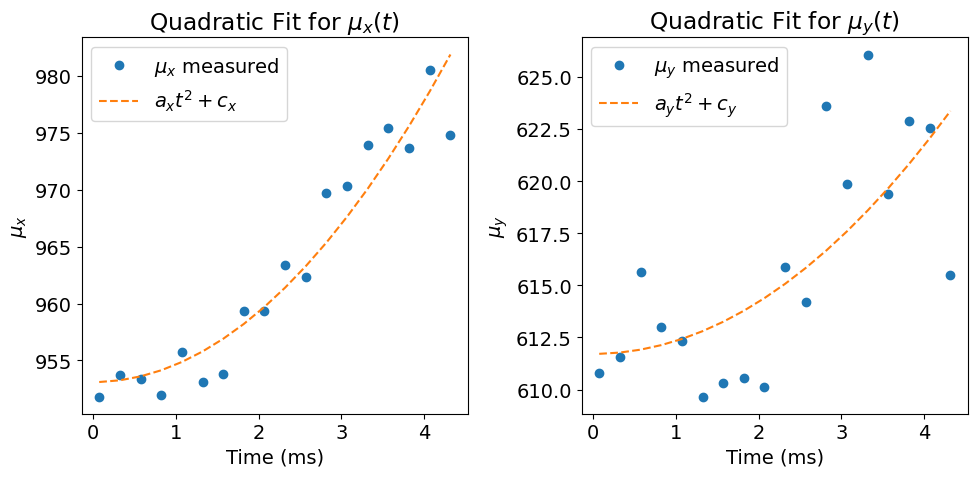

In [26]:
start = np.where(np.array(file_indices) == min_file)[0][0]
end = np.where(np.array(file_indices) == 40)[0][0] + 1
new_indices = file_indices[start:end]
t = dt * np.arange(len(new_indices)) + start_tof
t_ms = t * 1e3 

# Fit quadratic function to x0 values
def quadratic(t, a, c):
    return a * t**2 + c
popt_x_accel, cov_x = curve_fit(quadratic, t, x0_values[start:end])
popt_y_accel, cov_y = curve_fit(quadratic, t, y0_values[start:end])

# Plotting the quadratic fits
plt.figure(figsize=(10, 5))
plt.rcParams.update({'font.size': 14})
plt.subplot(1, 2, 1)
plt.plot(t_ms, x0_values[start:end], 'o', label=r'$\mu_x$ measured')
plt.plot(t_ms, quadratic(t, *popt_x_accel), label=r'$a_x t^2 + c_x$', linestyle='--')
plt.xlabel('Time (ms)')
plt.ylabel(r'$\mu_x$')
plt.title(r'Quadratic Fit for $\mu_x(t)$')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(t_ms, y0_values[start:end], 'o', label=r'$\mu_y$ measured')
plt.plot(t_ms, quadratic(t, *popt_y_accel), label=r'$a_y t^2 + c_y$', linestyle='--')
plt.xlabel('Time (ms)')
plt.ylabel(r'$\mu_y$')
plt.title(r'Quadratic Fit for $\mu_y(t)$')
plt.legend()
plt.tight_layout()
#plt.savefig("quadratic_fit_parameters.png", dpi=300)


In [27]:
# Estimating Pixel size
g = 9.81  # m/s^2
a_x = popt_x_accel[0]  # m/s^2
a_y = popt_y_accel[0]  # m/s^2

# Uncertainties
a_x_err = np.sqrt(cov_x[0,0])
a_y_err = np.sqrt(cov_y[0,0])

pixel_size_est = g / (2 * np.sqrt(a_x**2 + a_y**2)) * 1e6  # µm

partial_ax = -g * a_x / (2 * (a_x**2 + a_y**2)**(3/2)) * 1e6  # µm
partial_ay = -g * a_y / (2 * (a_x**2 + a_y**2)**(3/2)) * 1e6  # µ

pixel_size_error = np.sqrt((partial_ax**2 * a_x_err) + (partial_ay**2 * a_y_err))

print("Pixel size error:", round(pixel_size_error, 6), "µm")

print("Estimated pixel size:", pixel_size_est.round(6), "µm")

Pixel size error: 0.000619 µm
Estimated pixel size: 2.950438 µm


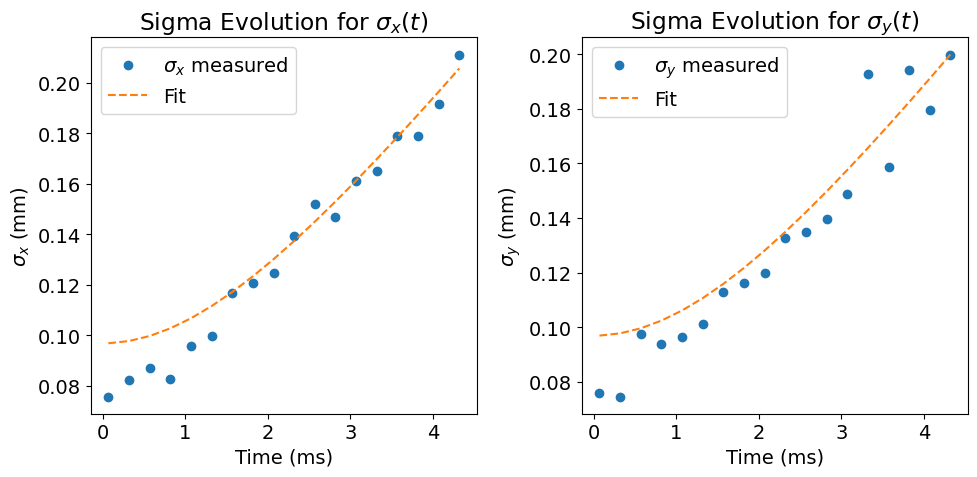

In [30]:
pixel_size = 3.45 * 1e-6  # actual pixel size in meters 
pixel_size = pixel_size_est * 1e-6  # convert µm to meters

sigma_x_values_meters = np.array(sigma_x_values[start:end]) * pixel_size
sigma_y_values_meters = np.array(sigma_y_values[start:end]) * pixel_size

sigma_x_values_mmeters = sigma_x_values_meters * 1e3
sigma_y_values_mmeters = sigma_y_values_meters * 1e3

u = 1.66053906660e-27  # kg
m_85rb = 84.91178974 * u  # kg
k_B = 1.380649e-23  # J/K

def sigma_evolution(t, sigma_0, T):
    return np.sqrt(sigma_0**2 + (k_B * T / m_85rb) * t ** 2)


# Fit the sigma evolution
popt_sigma_x, cov_sigma_x = curve_fit(sigma_evolution, t, sigma_x_values_meters, p0=[0.1, 0], bounds=(0, [np.inf, np.inf]))
popt_sigma_y, cov_sigma_y = curve_fit(sigma_evolution, t, sigma_y_values_meters, p0=[0.1, 0], bounds=(0, [np.inf, np.inf]))

# Plotting the sigma evolution
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(t_ms, sigma_x_values_mmeters, 'o', label=r'$\sigma_x$ measured')
plt.plot(t_ms, 1e3 * sigma_evolution(t, *popt_sigma_x), label='Fit', linestyle='--')
plt.xlabel('Time (ms)')
plt.ylabel(r'$\sigma_x$ (mm)')
plt.title(r'Sigma Evolution for $\sigma_x(t)$')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(t_ms, sigma_y_values_mmeters, 'o', label=r'$\sigma_y$ measured')
plt.plot(t_ms, 1e3 * sigma_evolution(t, *popt_sigma_y), label='Fit', linestyle='--')
plt.xlabel('Time (ms)')
plt.ylabel(r'$\sigma_y$ (mm)')
plt.title(r'Sigma Evolution for $\sigma_y(t)$')
plt.legend()
plt.tight_layout()
#plt.savefig("sigma_evolution.png", dpi=600)

In [29]:
T_opt = popt_sigma_x[1]
T_err = np.sqrt(cov_sigma_x[1][1])

print(f"Estimated temperature: {T_opt * 1e3:.6f} mK")
print(f"Uncertainty: {T_err * 1e3:.6f} mK")

Estimated temperature: 0.078062 mK
Uncertainty: 0.003045 mK


In [8]:
T_opt = popt_sigma_y[1]
T_err = np.sqrt(cov_sigma_y[1][1])

print(f"Estimated temperature: {T_opt * 1e3:.6f} mK")
print(f"Uncertainty: {T_err * 1e3:.6f} mK")

Estimated temperature: 0.016714 mK
Uncertainty: 0.001656 mK
